<a href="https://colab.research.google.com/github/thuyduongcoding/advanced-deep-learning/blob/main/Xception_and_EfficientNetB0_on_TF_Flowers_Dataset_ipynb_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1: Data augmentation and transfer learning {-}

This assignment aims at familiarizing you with training, validating and testing deep neural networks using data augmentation and transfer learning techniques. Here are the BASIC requirements of the assignment:

- Load the data.
- Process, normalize and resize the images.
- Build a CNN architecture of your choice (from this list of models https://www.tensorflow.org/api_docs/python/tf/keras/applications, except the VGG16 as in the demo code) with an obligatory use of the following two techniques:
    - Data augmentation. Several ideas for the data augmentation: use augmentation layers such as tf.keras.layers.RandomBrightness/RandomContrast/RandomCrop/RandomFlip/RandomHeight/RandomRotation/RandomTranslation/RandomWidth/RandomZoom, etc.
    - Transfer learning. Several ideas for the transfer learning: freeze all layers of the base model, un-freeze some layers of the base model, adjust the classification layers, etc.
- Train and validate the model to perform the image classification task.
- Evaluate the performance of the model on the test set.
- Visualize the model behaviour during the training.

The dataset is tf_flowers (https://www.tensorflow.org/datasets/catalog/tf_flowers) consists of 3,670 files belonging to 5 classes:
* daisy
* dandelion
* roses
* sunflowers
* tulips

### Submission {-}
The structure of submission folder should be organized as follows:

- ./\<StudentID>-assignment1-notebook.ipynb: Jupyter notebook containing source code.

The submission folder is named ADL-\<StudentID>-Assignment1 (e.g., ADL-2012345-Assigment1) and then compressed with the same name.

### Evaluation {-}
Assignment evaluation will be conducted on how you accomplish the assignment requirements. The model accuracy on the test set is one of the most important evaluation criteria. Therefore try to push it as high as possible. In addition, your code should conform to a Python coding convention such as PEP-8.

### Deadline {-}
Please visit Canvas for details.

## Load the dataset

In [ ]:
# Note: to enable GPU training in Colab, go to Runtime > Change runtime type > Hardware acceleration > Choose GPU from the drop-down list.

!pip install tensorflow_datasets

# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras import Model

In [ ]:
!pip install tensorflow_hub
import tensorflow_hub as hub

In [ ]:
# DO NOT CHANGE THIS CODE

#Load the tf_flowers dataset and split training/validation/test set.
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers', # Name of the dataset to load.
    split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'], # Split to training, validation and test set.
    with_info=True, # Return the dataset information and keep in 'metadata' variable.
    as_supervised=True,  # boolean, if True, the returned tf.data.Dataset will have a 2-tuple structure (input, label)
)

# Show the data information (metadata)
print("Metadata: " +str(metadata))

# Show the number of classes of the dataset
num_classes = metadata.features['label'].num_classes
print("Number of classes: " + str(num_classes))

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
Metadata: tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='/root/tensorflow_datasets/tf_flowers/3.0.1.incompleteO8WNPB',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflo

Image shape: (333, 500, 3)
(1, 333, 500, 3) tf.Tensor([2], shape=(1,), dtype=int64) tulips
(1, 212, 320, 3) tf.Tensor([3], shape=(1,), dtype=int64) sunflowers
(1, 240, 320, 3) tf.Tensor([3], shape=(1,), dtype=int64) sunflowers
(1, 240, 320, 3) tf.Tensor([4], shape=(1,), dtype=int64) roses
(1, 317, 500, 3) tf.Tensor([3], shape=(1,), dtype=int64) sunflowers


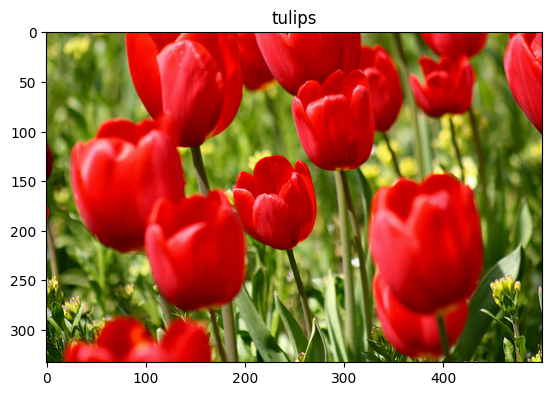

In [ ]:
# Show a data sample from the dataset
get_label_name = metadata.features['label'].int2str # Return the function mapping integer label to string label

# Get the first data sample in the training set
image, label = next(iter(train_ds))
plt.imshow(image) # Plot the image.
plt.title(get_label_name(label)) # Add the flower name to the plot.
print("Image shape: " + str(image.shape))

# Print some of image tensors
count = 0
for image, label in train_ds.batch(batch_size=1):
  if (count < 5):
    print(image.shape, label, get_label_name(label[0])) # Show image tensor information. See that the image tensors vary in size.
    count = count + 1

## Data processing and augmentation

In [ ]:
# Number of training and validation samples
num_training_examples = 0
num_validation_examples = 0
for example in train_ds:
    num_training_examples += 1
for example in val_ds:
    num_validation_examples += 1

In [ ]:
IMAGE_RES = 224
# Resize and normalize the image
def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    return image, label

# Data augmentation with random flip and random rotation
def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    return image, label

In [ ]:
# Prepare the data
BATCH_SIZE = 32
train_batches = train_ds.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).map(data_augment).prefetch(1)
validation_batches = val_ds.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_ds.map(format_image).batch(BATCH_SIZE).prefetch(1)

print(train_batches)
print(validation_batches)
print(test_batches)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


## 1. Freeze all layers of the base model (EfficientNetB0)

In [ ]:
# Using pre-trained EfficientNetB0 as the feature extractor layer
URL = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3))

In [ ]:
# Freeze all the weights
feature_extractor.trainable = False

In [ ]:
# Add classification on top of it
model = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(num_classes, activation="softmax")
])
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_11 (KerasLayer)  (None, 1280)             4049564   
                                                                 
 dense_8 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 4,055,969
Trainable params: 6,405
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
learning_rate = 1e-3  # Define the learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Compile the model
model.compile(
  optimizer= optimizer,
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
EPOCHS = 20
# Train the model
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/20
81/81 [==============================] - 11s 105ms/step - loss: 0.7511 - accuracy: 0.7505 - val_loss: 0.4604 - val_accuracy: 0.8584
Epoch 2/20
81/81 [==============================] - 8s 98ms/step - loss: 0.3767 - accuracy: 0.8902 - val_loss: 0.3422 - val_accuracy: 0.8820
Epoch 3/20
81/81 [==============================] - 8s 102ms/step - loss: 0.2925 - accuracy: 0.9163 - val_loss: 0.2911 - val_accuracy: 0.9056
Epoch 4/20
81/81 [==============================] - 9s 107ms/step - loss: 0.2508 - accuracy: 0.9210 - val_loss: 0.2625 - val_accuracy: 0.9165
Epoch 5/20
81/81 [==============================] - 9s 108ms/step - loss: 0.2190 - accuracy: 0.9366 - val_loss: 0.2472 - val_accuracy: 0.9183
Epoch 6/20
81/81 [==============================] - 8s 93ms/step - loss: 0.2032 - accuracy: 0.9408 - val_loss: 0.2354 - val_accuracy: 0.9238
Epoch 7/20
81/81 [==============================] - 9s 106ms/step - loss: 0.1834 - accuracy: 0.9510 - val_loss: 0.2280 - val_accuracy: 0.9220
Epoch 8

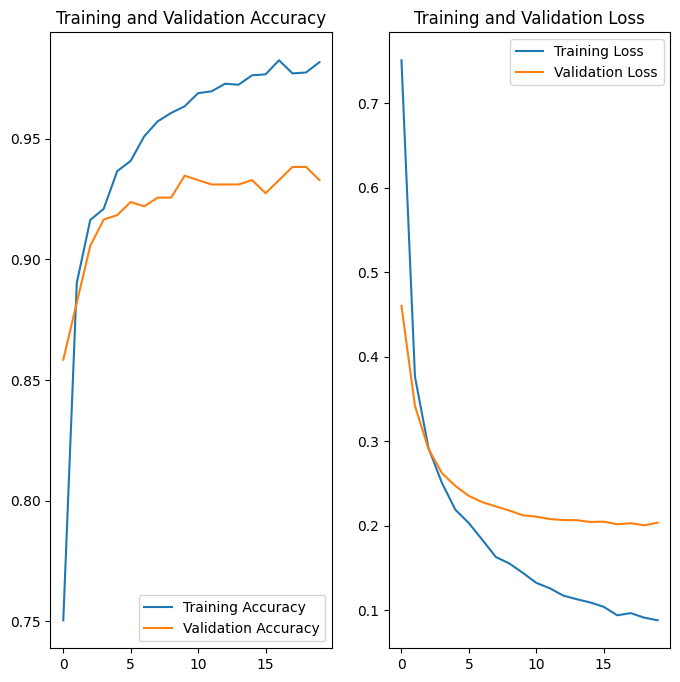

In [ ]:
# Visualize the training and validation accuracy/loss over time
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Evaluate the model accuracy
freeze_all_model = model
freeze_all_model_eval = freeze_all_model.evaluate(train_batches)
print("List of metrics" + str(freeze_all_model.metrics_names)) # List of possible metrics of the model evaluation, this is the metrics specified in the model.compile().

print("Test loss: " + str(freeze_all_model_eval[0])) # Test loss
print("Test accuracy: " + str(freeze_all_model_eval[1])) # Test accuracy

81/81 [==============================] - 9s 96ms/step - loss: 0.0792 - accuracy: 0.9801
List of metrics['loss', 'accuracy']
Test loss: 0.07918901741504669
Test accuracy: 0.9801478981971741


## 2. Unfreeze only top layers (Xception)

In [ ]:
# Initialize the model efficientnetb0 from tf.keras.applications
base_model_xception = tf.keras.applications.xception.Xception(
    weights='imagenet', # None for random initialization, or 'imagenet' for using pre-training on ImageNet.
    include_top=False, # Whether to include the 3 fully-connected layers at the top of the network.
    input_shape=(IMAGE_RES, IMAGE_RES, 3)) # Specify input input_shape

In [ ]:
# Show the number of layers in the base model
print("Number of layers in the base model: ", len(base_model_xception.layers))

Number of layers in the base model:  132


In [ ]:
# Extract the last layer from efficientnetb0
last_layer = base_model_xception.layers[-1].output
base_model_xception.trainable=False

# Add classification layers on top of it
x = Flatten()(last_layer) # Convert the last layer to a 1D tensor.
x = BatchNormalization()(x) # Add batch normalization layer.
x = Dense(64, activation='relu')(x) # Add a fully connected layer.
x = Dense(64, activation='relu')(x) # Add a fully connected layer.
x = Dropout(0.5)(x) # Add a dropout layer with probability 0.5.
pred = Dense(num_classes, activation='softmax')(x) # Add a fully connected layer with softmax activation function as the prediction output.

In [ ]:
# Fine-tune from this layer onwards
# Find the layer to start fine-tuning
for i, layer in enumerate(base_model_xception.layers):
    if layer.name == 'block14_sepconv1':
        start_fine_tuning = i
        break

# Unfreeze the layers from start_fine_tuning onwards
for layer in base_model_xception.layers[start_fine_tuning:]:
    layer.trainable = True

In [ ]:
# Define a new model by grouping layers into an object with training and inference features.
xception_unfreeze_top = Model(inputs=base_model_xception.input, outputs=pred)

# Print model summary. See the changes in the model structure and the number of trainable parameters.
xception_unfreeze_top.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [ ]:
# Compile the model
learning_rate = 1e-3  # Define the learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

xception_unfreeze_top.compile(optimizer=optimizer, # Use Adam optimizer
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']) # Model evaluation metric.

In [ ]:
# Set training epochs and batch size
training_epochs= 50

# Train the model
history_unfreeze_top = xception_unfreeze_top.fit(
  train_batches,
  validation_data=validation_batches,
  epochs=training_epochs,
  batch_size = 512
)

Epoch 1/50
81/81 [==============================] - 25s 204ms/step - loss: 4.3152 - accuracy: 0.6384 - val_loss: 1.7095 - val_accuracy: 0.8258
Epoch 2/50
81/81 [==============================] - 16s 199ms/step - loss: 2.2618 - accuracy: 0.7003 - val_loss: 3.0883 - val_accuracy: 0.8058
Epoch 3/50
81/81 [==============================] - 16s 196ms/step - loss: 1.2365 - accuracy: 0.7314 - val_loss: 0.9053 - val_accuracy: 0.8385
Epoch 4/50
81/81 [==============================] - 15s 191ms/step - loss: 0.9159 - accuracy: 0.7470 - val_loss: 0.5763 - val_accuracy: 0.8512
Epoch 5/50
81/81 [==============================] - 16s 199ms/step - loss: 1.4462 - accuracy: 0.7408 - val_loss: 0.6844 - val_accuracy: 0.7858
Epoch 6/50
81/81 [==============================] - 15s 188ms/step - loss: 1.2316 - accuracy: 0.7330 - val_loss: 1.0747 - val_accuracy: 0.8076
Epoch 7/50
81/81 [==============================] - 16s 193ms/step - loss: 0.9652 - accuracy: 0.7365 - val_loss: 0.6171 - val_accuracy: 0.8221

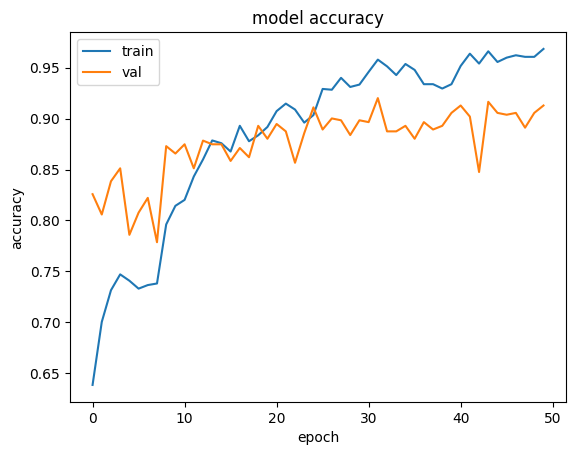

In [ ]:
# Visualize the training and validation accuracy over epochs
plt.plot(history_unfreeze_top.history['accuracy'])
plt.plot(history_unfreeze_top.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the model accuracy
unfreeze_top_model = xception_unfreeze_top
unfreeze_top_model_eval = unfreeze_top_model.evaluate(train_batches)
print("List of metrics" + str(unfreeze_top_model.metrics_names)) # List of possible metrics of the model evaluation, this is the metrics specified in the model.compile().

print("Test loss: " + str(unfreeze_top_model_eval[0])) # Test loss
print("Test accuracy: " + str(unfreeze_top_model_eval[1])) # Test accuracy

81/81 [==============================] - 14s 160ms/step - loss: 0.0486 - accuracy: 0.9817
List of metrics['loss', 'accuracy']
Test loss: 0.04862523823976517
Test accuracy: 0.9817049503326416
